In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.formula.api import ols

In [2]:
# load data
data = pd.read_csv('./all_params_w_utility105.csv')
data.head()

,Unnamed: 0,hot_spot_discover_rate,non_hot_spot_discover_rate,hot_spot_effect_size,avg_max_unfairness_rln,avg_mean_unfairness_rln,initial_unfairness_rln,avg_utility_mean_discover_rate,avg_utility_total_discover_n,avg_n_correct_hotspot,n_traces
0,0,1.0,0.50,1,0.269339,0.162631,0.007391,0.667727,33136.500000,15.935859,32
1,1,1.0,0.45,1,0.273956,0.172383,0.007391,0.632467,31389.562500,15.780938,16
2,2,1.0,0.40,1,0.297704,0.181402,0.007391,0.598123,29683.458333,15.666667,24
3,3,1.0,0.35,1,0.298790,0.189401,0.007391,0.562082,27896.687500,15.464844,16
4,4,1.0,0.30,1,0.331910,0.206556,0.007391,0.526772,26151.208333,15.248750,24


In [3]:
data['max_increase_unfairness_rln'] = data['avg_max_unfairness_rln'] - data['initial_unfairness_rln']
data['avg_increase_unfairness_rln'] = data['avg_mean_unfairness_rln'] - data['initial_unfairness_rln']

In [4]:
# fit lm model
lm = ols('max_increase_unfairness_rln ~ (scale(hot_spot_discover_rate) + scale(non_hot_spot_discover_rate) + scale(hot_spot_effect_size))**2', data=data).fit()

In [5]:
lm.params

Intercept                                                          0.306258
scale(hot_spot_discover_rate)                                      0.008989
scale(non_hot_spot_discover_rate)                                 -0.034629
scale(hot_spot_effect_size)                                       -0.000718
scale(hot_spot_discover_rate):scale(non_hot_spot_discover_rate)    0.001749
scale(hot_spot_discover_rate):scale(hot_spot_effect_size)         -0.000536
scale(non_hot_spot_discover_rate):scale(hot_spot_effect_size)      0.000940
dtype: float64

In [6]:
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:     max_increase_unfairness_rln   R-squared:                       0.738
Model:                                     OLS   Adj. R-squared:                  0.722
Method:                          Least Squares   F-statistic:                     46.09
Date:                         Tue, 12 Nov 2024   Prob (F-statistic):           2.08e-26
Time:                                 19:53:36   Log-Likelihood:                 254.98
No. Observations:                          105   AIC:                            -496.0
Df Residuals:                               98   BIC:                            -477.4
Df Model:                                    6                                         
Covariance Type:                     nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025 

In [22]:
# get the anova table
table = sm.stats.anova_lm(lm, typ=2)
table['eta_sq'] = table['sum_sq'] / table['sum_sq'].sum()
# remove residuals
table = table.iloc[:-1]
# get the ranking of the features based on sum of squares of anova table
table['sum_sq_rank'] = table['sum_sq'].rank(ascending=False)

# identify all variables p<=0.05
statistically_significant_variables = table[table['PR(>F)'] <= 0.05].index

In [8]:
table

,sum_sq,df,F,PR(>F),eta_sq,sum_sq_rank
scale(hot_spot_discover_rate),0.008484,1.0,17.392052,6.573900e-05,0.046437,2.0
scale(non_hot_spot_discover_rate),0.125916,1.0,258.118097,3.276745e-29,0.689176,1.0
scale(hot_spot_effect_size),0.000054,1.0,0.110810,7.399347e-01,0.000296,5.0
scale(hot_spot_discover_rate):scale(non_hot_spot_discover_rate),0.000321,1.0,0.658269,4.191380e-01,0.001758,3.0
scale(hot_spot_discover_rate):scale(hot_spot_effect_size),0.000030,1.0,0.061797,8.041978e-01,0.000165,6.0
scale(non_hot_spot_discover_rate):scale(hot_spot_effect_size),0.000093,1.0,0.190372,6.635671e-01,0.000508,4.0


### Get sampling configuration of 2-coverage and 3-coverage

In [9]:
from covertable import make, sorters, criteria
X = data[['hot_spot_discover_rate', 'non_hot_spot_discover_rate', 'hot_spot_effect_size']]
hot_spot_discover_rate_unique = X['hot_spot_discover_rate'].unique()
non_hot_spot_discover_rate_unique = X['non_hot_spot_discover_rate'].unique()
hot_spot_effect_size_unique = X['hot_spot_effect_size'].unique()

sample_2 = make([hot_spot_discover_rate_unique, non_hot_spot_discover_rate_unique, hot_spot_effect_size_unique], length=2)
sample_2 = [tuple(x) for x in sample_2]
print(len(sample_2), len(data))

35 105


In [11]:
sample_data_2 = data[data[['hot_spot_discover_rate', 'non_hot_spot_discover_rate', 'hot_spot_effect_size']].apply(tuple, axis=1).isin(sample_2)]

## Fit regression model for sampled data

In [13]:
# fit lm for 2-coverage sampling
lm_2 = ols('max_increase_unfairness_rln ~ (scale(hot_spot_discover_rate) + scale(non_hot_spot_discover_rate) + scale(hot_spot_effect_size))**2', data=sample_data_2).fit()

In [14]:
# compute the MSE for original lm
mse = np.mean((lm.predict(data) - data['max_increase_unfairness_rln'])**2)
# compute the MSE for 2-coverage sampling lm
mse_2 = np.mean((lm_2.predict(data) - data['max_increase_unfairness_rln'])**2)

print(mse, mse_2)

0.0004552998820509805 0.000642174774719797


In [23]:
# get the anova table for 2-coverage sampling
table_2 = sm.stats.anova_lm(lm_2, typ=2)

# remove residuals
table_2 = table_2.iloc[:-1]

# get the ranking of the features based on sum of squares of anova table
table_2['sum_sq_rank'] = table_2['sum_sq'].rank(ascending=False)

In [16]:
lm_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     max_increase_unfairness_rln   R-squared:                       0.841
Model:                                     OLS   Adj. R-squared:                  0.807
Method:                          Least Squares   F-statistic:                     24.66
Date:                         Tue, 12 Nov 2024   Prob (F-statistic):           5.81e-10
Time:                                 19:54:07   Log-Likelihood:                 93.231
No. Observations:                           35   AIC:                            -172.5
Df Residuals:                               28   BIC:                            -161.6
Df Model:                                    6                                         
Covariance Type:                     nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                           0.3047      0.003     94.849      0.000       0.298       0.311
scale(hot_spot_discover_rate)                                       0.0125      0.003      3.704      0.001       0.006       0.019
scale(non_hot_spot_discover_rate)                                  -0.0381      0.003    -11.580      0.000      -0.045      -0.031
scale(hot_spot_effect_size)                                         0.0048      0.003      1.437      0.162      -0.002       0.012
scale(hot_spot_discover_rate):scale(non_hot_spot_discover_rate)    -0.0022      0.003     -0.681      0.501      -0.009       0.004
scale(hot_spot_discover_rate):scale(hot_spot_effect_size)           0.0069      0.003      2.006      0.055      -0.000       0.014
scale(non_hot_spot_discover_rate):scale(hot_spot_effect_size)      -0.0042      0.004     -1.180      0.248      -0.011       0.003
==============================================================================
Omnibus:                        4.152   Durbin-Watson:                   0.950
Prob(Omnibus):                  0.125   Jarque-Bera (JB):                2.831
Skew:                           0.651   Prob(JB):                        0.243
Kurtosis:                       3.498   Cond. No.                         1.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
from sklearn.metrics import r2_score
# compute the R2 for 2 lm
r2 = r2_score(data['max_increase_unfairness_rln'], lm.predict(data))
r2_2 = r2_score(data['max_increase_unfairness_rln'], lm_2.predict(data))
print(r2, r2_2)

0.738339693762782 0.6309429129345043


## Compare the feature ranking between baseline and sampling

In [72]:
# compute Kendall Tau
from scipy.stats import kendalltau
print(kendalltau(table.loc[statistically_significant_variables]['sum_sq_rank'], table_2.loc[statistically_significant_variables]['sum_sq_rank']))

KendalltauResult(correlation=1.0, pvalue=1.0)


In [71]:
# compute Rank Biased Overlap
from rbo import rbo
# get the ranked features based on sum_sq_rank for statistically significant variables
ranked_features_gt_sig = table.loc[statistically_significant_variables].sort_values(by=['sum_sq_rank']).index.to_list()
ranked_features_2_sig = table_2.loc[statistically_significant_variables].sort_values(by=['sum_sq_rank']).index.to_list()

# compute Rank Biased Overlap
print(rbo.RankingSimilarity(ranked_features_gt_sig, ranked_features_2_sig).rbo_ext(p=0.8))

1.0


In [70]:
ranked_features_2

['scale(non_hot_spot_discover_rate)',
 'scale(hot_spot_discover_rate)',
 'scale(hot_spot_discover_rate):scale(hot_spot_effect_size)',
 'scale(hot_spot_effect_size)',
 'scale(non_hot_spot_discover_rate):scale(hot_spot_effect_size)',
 'scale(hot_spot_discover_rate):scale(non_hot_spot_discover_rate)']

## Trade-off Analysis

In [13]:

# Adjusting the Pareto efficiency function for the new criteria
def is_pareto_efficient_minimize_cost(costs, returns):
    """
    Identify the Pareto efficient points for minimizing costs and maximizing returns
    :param costs: An array of costs to minimize
    :param returns: An array of returns to maximize
    :return: A boolean array, where True indicates Pareto efficiency
    """
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.logical_not(np.logical_and(returns[is_efficient] <= returns[i], costs[is_efficient] >= c))
            is_efficient[i] = True  # And keep self
    return is_efficient

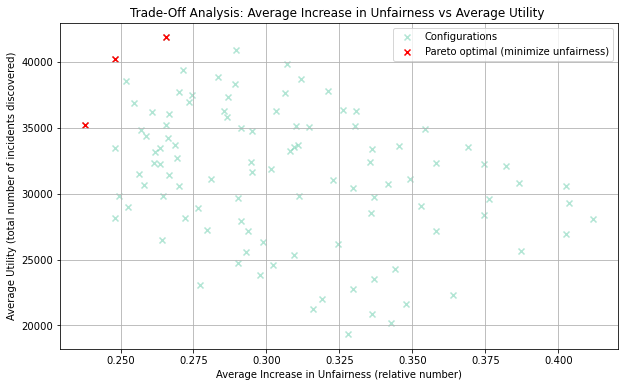

In [14]:
pareto_minimize_cost = is_pareto_efficient_minimize_cost(data['max_increase_unfairness_rln'].values, data['avg_utility_total_discover_n'].values)

# Re-plotting the data with updated Pareto optimal points
plt.figure(figsize=(10, 6))
plt.scatter(data['max_increase_unfairness_rln'], data['avg_utility_total_discover_n'], alpha=0.5, label='Configurations', marker='x', color='mediumaquamarine')
plt.scatter(data['max_increase_unfairness_rln'][pareto_minimize_cost], data['avg_utility_total_discover_n'][pareto_minimize_cost], color='r', marker='x', label='Pareto optimal (minimize unfairness)')
plt.title('Trade-Off Analysis: Average Increase in Unfairness vs Average Utility ')
plt.xlabel('Average Increase in Unfairness (relative number)')
plt.ylabel('Average Utility (total number of incidents discovered)')
plt.grid()
plt.legend()

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import pi
from sklearn.preprocessing import MinMaxScaler

def plot_spider_chart(df, features, path=None):
    # Number of variables we're plotting.
    num_vars = len(features)

    # Compute angle each bar is centered on:
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is circular, so we need to "complete the loop" and append the start to the end.
    angles += angles[:1]

    sns.set_context('paper', font_scale=1.4)

    # Initialize the spider plot
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    # Draw one axe per variable and add labels
    plt.xticks(angles[:-1], features, size=20)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=15)
    plt.ylim(0, 1)

    line_styles = ['solid', (0, (5, 10)),'dotted', (5, (10, 3)), 'dashdot']  # List of line styles

    i = 0
    for idx, row in df.iterrows():
        values = row.values.flatten().tolist()
        values += values[:1]
        line_style = line_styles[i % len(line_styles)]  # Get the line style based on the index
        ax.plot(angles, values, linewidth=1, linestyle=line_style, label=f'Config {idx}')
        ax.fill(angles, values, alpha=0.1)
        i += 1


    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    if path:
        plt.savefig(path, format="pdf", bbox_inches="tight")

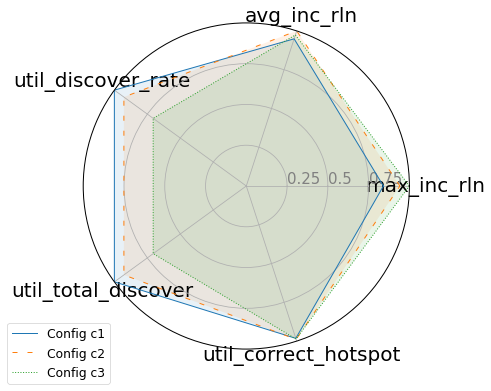

In [18]:
scaler = MinMaxScaler()
features = ['max_increase_unfairness_rln', 'avg_increase_unfairness_rln', 'avg_utility_mean_discover_rate', 'avg_utility_total_discover_n',
       'avg_n_correct_hotspot']
print()
df_normalized = pd.DataFrame(scaler.fit_transform(data[features]), 
                             columns=features)
for f in features[:2]:
    df_normalized[f] = 1 - df_normalized[f]
# new_feature_names = ['1-max_increase_unfairness_rln', '1-avg_mean_unfairness_rln', 'avg_utility_mean_discover_rate', 'avg_utility_total_discover_n',
       # 'avg_n_correct_hotspot']
new_feature_names = ['max_inc_rln', 'avg_inc_rln', 'util_discover_rate', 'util_total_discover',
       'util_correct_hotspot']
pareto_data_features = df_normalized[pareto_minimize_cost][features]
pareto_data_features.index = ['c1', 'c2', 'c3']
plot_spider_chart(pareto_data_features, new_feature_names, 'radar.pdf')

In [19]:
data[pareto_minimize_cost]

,Unnamed: 0,hot_spot_discover_rate,non_hot_spot_discover_rate,hot_spot_effect_size,avg_max_unfairness_rln,avg_mean_unfairness_rln,initial_unfairness_rln,avg_utility_mean_discover_rate,avg_utility_total_discover_n,avg_n_correct_hotspot,n_traces,max_increase_unfairness_rln,avg_increase_unfairness_rln
70,70,1.00,0.5,3,0.273019,0.149605,0.007391,0.843608,41853.125,16.442813,32,0.265628,0.142214
77,77,0.95,0.5,3,0.255429,0.143653,0.007391,0.810846,40227.125,16.455547,32,0.248038,0.136262
98,98,0.80,0.5,3,0.245362,0.146700,0.007391,0.710151,35230.000,16.451250,16,0.237971,0.139309
